# Setup SAM

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Project_XLA
CODE_DIR = 'SAM'
!git clone https://github.com/yuval-alaluf/SAM.git $CODE_DIR

%cd SAM
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

/content/drive/MyDrive/Colab Notebooks/Project_XLA
/content/drive/MyDrive/Colab Notebooks/Project_XLA/SAM
Archive:  ninja-linux.zip
  inflating: /usr/local/bin/ninja    
update-alternatives: using /usr/local/bin/ninja to provide /usr/bin/ninja (ninja) in auto mode


In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Project_XLA/SAM


In [ ]:
from argparse import Namespace
import os
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

os.chdir("/content/drive/MyDrive/Colab Notebooks/Project_XLA/SAM")
sys.path.append(".")
sys.path.append("..")

from datasets.augmentations import AgeTransformer
from utils.common import tensor2im
from models.psp import pSp

In [ ]:
def run_alignment(image_path):
    import dlib
    from scripts.align_all_parallel import align_face
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    aligned_image = align_face(filepath=image_path, predictor=predictor)
    print("Aligned image has shape: {}".format(aligned_image.size))
    return aligned_image

In [ ]:
EXPERIMENT_TYPE = 'ffhq_aging'

In [ ]:
current_directory = os.getcwd()
os.path.join(os.path.dirname(current_directory), "pretrained_models")

'/content/drive/MyDrive/Colab Notebooks/Project_XLA/pretrained_models'

In [ ]:
def get_download_model_command(file_id, file_name):
    """ Get wget download command for downloading the desired model and save to directory ../pretrained_models. """
    current_directory = os.getcwd()
    save_path = r"./pretrained_models"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
    return url

In [ ]:
MODEL_PATHS = {
    "ffhq_aging": {"id": "1XyumF6_fdAxFmxpFcmPf-q84LU_22EMC", "name": "sam_ffhq_aging.pt"}
}

path = MODEL_PATHS[EXPERIMENT_TYPE]
download_command = get_download_model_command(file_id=path["id"], file_name=path["name"])

In [ ]:
!wget {download_command}

In [ ]:
EXPERIMENT_DATA_ARGS = {
    "ffhq_aging": {
        "model_path": "./pretrained_models/sam_ffhq_aging.pt",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    }
}

In [ ]:
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[EXPERIMENT_TYPE]

In [ ]:
model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')

In [ ]:
opts = ckpt['opts']
pprint.pprint(opts)

{'aging_lambda': 5.0,
 'batch_size': 6,
 'board_interval': 50,
 'checkpoint_path': None,
 'cycle_lambda': 1.0,
 'dataset_type': 'ffhq_aging',
 'device': 'cuda',
 'exp_dir': '',
 'id_lambda': 0.1,
 'image_interval': 100,
 'input_nc': 4,
 'l2_lambda': 0.25,
 'l2_lambda_aging': 0.25,
 'l2_lambda_crop': 1.0,
 'label_nc': 0,
 'learning_rate': 0.0001,
 'lpips_lambda': 0.1,
 'lpips_lambda_aging': 0.1,
 'lpips_lambda_crop': 0.6,
 'max_steps': 500000,
 'optim_name': 'ranger',
 'output_size': 1024,
 'pretrained_psp_path': '',
 'save_interval': 2500,
 'start_from_encoded_w_plus': True,
 'start_from_latent_avg': False,
 'stylegan_weights': '',
 'target_age': 'uniform_random',
 'test_batch_size': 6,
 'test_workers': 6,
 'train_decoder': False,
 'use_weighted_id_loss': True,
 'val_interval': 2500,
 'w_norm_lambda': 0.005,
 'workers': 6}


In [ ]:
opts['checkpoint_path'] = model_path

In [ ]:
opts = Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading SAM from checkpoint: ./pretrained_models/sam_ffhq_aging.pt
Model successfully loaded!


In [ ]:
import imageio
from tqdm import tqdm
import matplotlib
from IPython.display import HTML
from base64 import b64encode

matplotlib.use('module://ipykernel.pylab.backend_inline')
%matplotlib inline


def generate_mp4(out_name, images, kwargs):
    writer = imageio.get_writer(out_name + '.mp4', **kwargs)
    for image in images:
        writer.append_data(image)
    writer.close()


def run_on_batch_to_vecs(inputs, net):
    _, result_batch = net(inputs.to("cuda").float(), return_latents=True, randomize_noise=False, resize=False)
    return result_batch.cpu()


def get_result_from_vecs(vectors_a, vectors_b, alpha):
    results = []
    for i in range(len(vectors_a)):
        cur_vec = vectors_b[i] * alpha + vectors_a[i] * (1 - alpha)
        res = net(cur_vec.cuda(), randomize_noise=False, input_code=True, input_is_full=True, resize=False)
        results.append(res[0])
    return results


def show_mp4(filename, width=400):
    mp4 = open(filename + '.mp4', 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML("""
    <video width="%d" controls autoplay loop>
        <source src="%s" type="video/mp4">
    </video>
    """ % (width, data_url)))

In [ ]:
def run_SAM_video(img_path):
  os.chdir(r"/content/drive/MyDrive/Colab Notebooks/Project_XLA/SAM")
  SEED = 42
  np.random.seed(SEED)

  img_transforms = EXPERIMENT_ARGS['transform']
  n_transition = 25
  kwargs = {'fps': 40}
  save_path = "/content/drive/MyDrive/Colab Notebooks/Project_XLA/results_sam"
  os.makedirs(save_path, exist_ok=True)

  #################################################################
  # TODO: define your image paths here to be fed into the model
  #################################################################
  # root_dir = 'notebooks/images'
  # ims = ['test']
  im_paths = [img_path]

  # NOTE: Please make sure the images are pre-aligned!

  target_ages = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80]
  age_transformers = [AgeTransformer(target_age=age) for age in target_ages]

  for image_path in im_paths:
      image_name = os.path.basename(image_path)
      print(f'Working on image: {image_name}')
      aligned_image = run_alignment(image_path)

      original_image = aligned_image
      input_image = img_transforms(original_image)
      all_vecs = []
      for idx, age_transformer in enumerate(age_transformers):

          input_age_batch = [age_transformer(input_image.cpu()).to('cuda')]
          input_age_batch = torch.stack(input_age_batch)

          # get latent vector for the current target age amount
          with torch.no_grad():
              result_vec = run_on_batch_to_vecs(input_age_batch, net)
              result_image = get_result_from_vecs([result_vec], result_vec, 0)[0]
              all_vecs.append([result_vec])

      images = []
      for i in range(1, len(target_ages)):
          alpha_vals = np.linspace(0, 1, n_transition).tolist()
          for alpha in tqdm(alpha_vals):
              result_image = get_result_from_vecs(all_vecs[i-1], all_vecs[i], alpha)[0]
              output_im = tensor2im(result_image)
              images.append(np.array(output_im))

      animation_path = os.path.join(save_path, f"{image_name}_animation")
      generate_mp4(animation_path, images, kwargs)
      # show_mp4(animation_path)
      # FIX
      return animation_path + ".mp4"

def run_on_batch(inputs, net):
    result_batch = net(inputs.to("cuda").float(), randomize_noise=False, resize=False)
    return result_batch

def run_SAM_img(image_path,target_age):
  os.chdir(r"/content/drive/MyDrive/Colab Notebooks/Project_XLA/SAM")
  aligned_image = run_alignment(image_path)
  img_transforms = EXPERIMENT_ARGS['transform']
  input_image = img_transforms(aligned_image)

  # we'll run the image on multiple target ages
  target_ages = [target_age]
  age_transformers = [AgeTransformer(target_age=age) for age in target_ages]

  # for each age transformed age, we'll concatenate the results to display them side-by-side
  # results = np.array(aligned_image.resize((1024, 1024)))
  for age_transformer in age_transformers:
      print(f"Running on target age: {age_transformer.target_age}")
      with torch.no_grad():
          input_image_age = [age_transformer(input_image.cpu()).to('cuda')]
          input_image_age = torch.stack(input_image_age)
          result_tensor = run_on_batch(input_image_age, net)[0]
          result_image = tensor2im(result_tensor)
  return result_image


In [ ]:
rest = run_SAM_video("/content/drive/MyDrive/Colab Notebooks/Project_XLA/uploads/test4.jpg")
rest

Working on image: test4.jpg


RuntimeError: Unable to open file: /content/drive/MyDrive/Colab Notebooks/Project_XLA/uploads/test4.jpg

Aligned image has shape: (256, 256)
Running on target age: 70


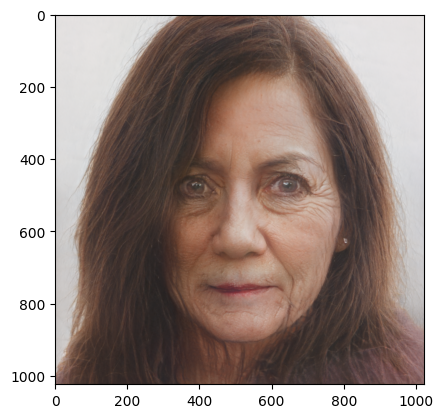

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(run_SAM_img("/content/drive/MyDrive/Colab Notebooks/Project_XLA/uploads/test4.jpg",70))

# Setup Lifespan

In [ ]:
!pip install flask_ngrok
!pip install pyngrok==4.1.1
!ngrok authtoken 2a6F7fC1ZD1Aa409WUb7wXfpK6T_2Zfg3oJ29p6hTxpP5kdij

  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-4.1.1-py3-none-any.whl size=15963 sha256=981d575958e283384c8f76de1b54bfd5017b456624370489d26528b8df351ba1
  Stored in directory: /root/.cache/pip/wheels/4c/7c/4c/632fba2ea8e88d8890102eb07bc922e1ca8fa14db5902c91a8
Successfully built pyngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 921.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 9.8 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=5058dc750c192d4a3097bb1126b7e5603bf6d1fd72d8702cded7c4db4d65d2ab
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Project_XLA
# !git clone https://github.com/royorel/Lifespan_Age_Transformation_Synthesis
%cd ./Lifespan_Age_Transformation_Synthesis
!pip3 install -r requirements.txt

/content/drive/MyDrive/Colab Notebooks/Project_XLA
/content/drive/MyDrive/Colab Notebooks/Project_XLA/Lifespan_Age_Transformation_Synthesis
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 21.3 MB/s eta 0:00:00
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408194 sha256=a95aaa5b6330042f22cf48799ed6e2690f90882f38474800e28293c388971970
  Stored in directory: /root/.cache/pip/wheels/42/29/49/5bed207bac4578e4d2c0c5fc0226bfd33a7e2953ea56356855
Successfully built visdom


In [ ]:
# !python download_models.py

In [ ]:
# Install required libraries
!pip install flask torch deepface
!pip install flask_ngrok

In [ ]:
os.chdir("../Lifespan_Age_Transformation_Synthesis")

In [ ]:
!python download_models.py

  0% 2.38k/213M [00:00<3:51:29, 15.3kB/s]Google Drive download failed.
Trying do download from alternate server

  0% 0.00/213M [00:00<?, ?B/s]
  0% 0.00/213M [00:00<?, ?B/s]
  0% 131k/213M [00:00<14:16, 249kB/s]
  0% 918k/213M [00:00<02:01, 1.74MB/s]
  2% 4.46M/213M [00:00<00:22, 9.08MB/s]
  5% 10.1M/213M [00:00<00:10, 20.2MB/s]
  8% 16.1M/213M [00:00<00:06, 30.3MB/s]
 10% 21.2M/213M [00:01<00:05, 35.2MB/s]
 12% 26.5M/213M [00:01<00:04, 39.7MB/s]
 15% 32.8M/213M [00:01<00:03, 46.1MB/s]
 18% 39.3M/213M [00:01<00:03, 51.5MB/s]
 21% 45.0M/213M [00:01<00:03, 52.3MB/s]
 24% 50.9M/213M [00:01<00:03, 53.3MB/s]
 27% 56.5M/213M [00:01<00:03, 46.1MB/s]
 29% 62.1M/213M [00:01<00:03, 48.7MB/s]
 32% 68.8M/213M [00:01<00:02, 53.0MB/s]
 35% 75.2M/213M [00:02<00:02, 55.7MB/s]
 38% 81.8M/213M [00:02<00:02, 58.3MB/s]
 41% 87.8M/213M [00:02<00:02, 53.8MB/s]
 44% 93.5M/213M [00:02<00:02, 54.4MB/s]
 46% 99.1M/213M [00:02<00:02, 51.1MB/s]
 49% 105M/213M [00:02<00:02, 53.3MB/s] 
 52% 111M/213M [00:02<00:01,

In [ ]:
!pip install flask torch deepface
!pip install flask_ngrok
!pip install deepface
!pip install pyngrok==4.1.1
!ngrok authtoken 2a6F7fC1ZD1Aa409WUb7wXfpK6T_2Zfg3oJ29p6hTxpP5kdij

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Project_XLA/Lifespan_Age_Transformation_Synthesis


In [ ]:
# Import necessary modules
# os.chdir("/content/drive/MyDrive/Colab Notebooks/Project_XLA/Lifespan_Age_Transformation_Synthesis")
import os
import torch
from deepface import DeepFace
from options.test_options import TestOptions
from data.data_loader import CreateDataLoader
from models_lifespan.models import create_model
import util.util as util
from util.visualizer import Visualizer
from flask import Flask, render_template, request, send_file, send_from_directory
from PIL import Image
from io import BytesIO
from flask_ngrok import run_with_ngrok
from PIL import Image
import numpy as np
import base64
import requests
from moviepy.editor import VideoFileClip
from werkzeug.utils import secure_filename

24-01-20 01:37:40 - Directory /root/.deepface created
24-01-20 01:37:40 - Directory /root/.deepface/weights created


In [ ]:
opt = TestOptions().parse(save=False)
opt.display_id = 0
opt.nThreads = 1
opt.batchSize = 1
opt.serial_batches = True
opt.no_flip = True
opt.in_the_wild = True
opt.traverse = True
opt.interp_step = 1

data_loader = CreateDataLoader(opt)
dataset = data_loader.load_data()
visualizer = Visualizer(opt)

usage: colab_kernel_launcher.py [-h] [--name NAME] [--gpu_ids GPU_IDS]
                                [--checkpoints_dir CHECKPOINTS_DIR] [--batchSize BATCHSIZE]
                                [--loadSize LOADSIZE] [--fineSize FINESIZE] [--input_nc INPUT_NC]
                                [--output_nc OUTPUT_NC] [--dataroot DATAROOT]
                                [--sort_classes SORT_CLASSES] [--sort_order SORT_ORDER]
                                [--resize_or_crop RESIZE_OR_CROP] [--serial_batches] [--no_flip]
                                [--nThreads NTHREADS] [--max_dataset_size MAX_DATASET_SIZE]
                                [--display_single_pane_ncols DISPLAY_SINGLE_PANE_NCOLS]
                                [--display_winsize DISPLAY_WINSIZE] [--display_port DISPLAY_PORT]
                                [--display_id DISPLAY_ID]
                                [--use_modulated_conv USE_MODULATED_CONV]
                                [--conv_weight_norm CONV_WEIGHT_NO

------------ Options -------------
activation: lrelu
batchSize: 1
checkpoints_dir: ./checkpoints
compare_to_trained_class: 1
compare_to_trained_outputs: False
conv_weight_norm: True
dataroot: ./datasets/males/
debug_mode: False
decoder_norm: pixel
deploy: False
display_id: 1
display_port: 8097
display_single_pane_ncols: 6
display_winsize: 256
fineSize: 256
full_progression: False
gen_dim_per_style: 50
gpu_ids: [0]
how_many: 50
id_enc_norm: pixel
image_path_file: None
in_the_wild: False
input_nc: 3
interp_step: 0.5
isTrain: False
loadSize: 256
make_video: False
max_dataset_size: inf
nThreads: 4
n_adaptive_blocks: 4
n_downsample: 2
name: debug
ngf: 64
no_cond_noise: False
no_flip: False
no_moving_avg: False
normalize_mlp: True
ntest: inf
output_nc: 3
phase: test
random_seed: -1
resize_or_crop: resize_and_crop
results_dir: ./results/
serial_batches: False
sort_classes: True
sort_order: ['0-2', '3-6', '7-9', '15-19', '30-39', '50-69']
trained_class_jump: 1
traverse: False
use_modulated_con

In [ ]:
opt.name = 'males_model'
model_male = create_model(opt)
opt.name = 'females_model'
model_female = create_model(opt)

Generator(
  (id_encoder): IdentityEncoder(
    (encoder): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): EqualConv2d(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      )
      (2): PixelNorm()
      (3): ReLU(inplace=True)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): EqualConv2d(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      )
      (6): PixelNorm()
      (7): ReLU(inplace=True)
      (8): ReflectionPad2d((1, 1, 1, 1))
      (9): EqualConv2d(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
      )
      (10): PixelNorm()
      (11): ReLU(inplace=True)
      (12): ResnetBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): EqualConv2d(
            (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
          )
          (2): PixelNorm()
          (3): ReLU(inplace=True)
          (4): ReflectionPad2d((1, 1, 1, 1))
          (5): EqualConv2d(

#run web

In [ ]:
# Create Flask app
templates_folder = '/content/drive/MyDrive/Colab Notebooks/Project_XLA/templates'
app = Flask(__name__, template_folder=templates_folder)
app.config['UPLOAD_FOLDER'] = '/content/drive/MyDrive/Colab Notebooks/Project_XLA/uploads'
app.config['ALLOWED_EXTENSIONS'] = {'jpg', 'jpeg', 'png', 'gif'}
run_with_ngrok(app)  # Start ngrok when the app is run

# Create the 'uploads' folder if it doesn't exist
os.makedirs(app.config['UPLOAD_FOLDER'], exist_ok=True)

def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in app.config['ALLOWED_EXTENSIONS']

def result_SAM(uploaded_file, chosen_age):
    results_dir = "/content/drive/MyDrive/Colab Notebooks/Project_XLA/Lifespan_Age_Transformation_Synthesis/results"
    # Xóa tất cả các file trong thư mục results
    for file in os.listdir(results_dir):
        try:
            os.remove(os.path.join(results_dir, file))
        except OSError as e:
            # File không xóa được
            pass

    # Use the secure filename to avoid security issues
    filename = secure_filename(uploaded_file.filename)
    print("file name:",filename)
    filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
    print("file path:",filepath)
    uploaded_file.save(filepath)

    os.chdir("/content/drive/MyDrive/Colab Notebooks/Project_XLA/SAM")


    if chosen_age is None or chosen_age == '':
      sam_video_file = run_SAM_video(filepath)
      print("sam_video_file:", sam_video_file)

      output_file = "/content/drive/MyDrive/Colab Notebooks/Project_XLA/Lifespan_Age_Transformation_Synthesis/results/converted_video_sam.mp4"
      codec = "libx264"

      video = VideoFileClip(sam_video_file)
      video.write_videofile(output_file, codec=codec)
      output_file = r"results/converted_video_sam.mp4"
      return None, output_file,filepath,filename

    # Assuming run_SAM_img returns a valid image or array
    sam_img = run_SAM_img(filepath, chosen_age)

    # Save the image to a file (temporary file or specified path)
    os.makedirs('temps', exist_ok=True)
    temp_img_path = os.path.join('temps', 'temp_image.jpg')
    plt.imsave(temp_img_path, sam_img)

    # Open the saved image with Pillow
    sam_pil_img = Image.open(temp_img_path)
    sam_pil_img = sam_pil_img.resize((350, 350))
    # Save the result image to a BytesIO object
    sam_img_io = BytesIO()
    sam_pil_img.save(sam_img_io, 'JPEG')
    sam_img_io.seek(0)

    # Encode the result image to base64 for embedding in HTML
    sam_image_base64 = base64.b64encode(sam_img_io.read()).decode('utf-8')
    torch.cuda.empty_cache()
    torch.cuda.current_device().free()
    return sam_image_base64, None,filepath,filename

def process_image(uploaded_file, chosen_age,filename,filepath):
    # Use the secure filename to avoid security issues
    os.chdir("/content/drive/MyDrive/Colab Notebooks/Project_XLA/Lifespan_Age_Transformation_Synthesis")

    # # filename = secure_filename(uploaded_file.filename)
    # filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)

    # uploaded_file.save(filepath)
    # print(filepath)

    objs = DeepFace.analyze(img_path=filepath, actions=["gender"])
    gender = objs[0]["dominant_gender"]
    print("done gender detect")


    model = model_male if gender == "Man" else model_female
    model.eval()

    torch.cuda.empty_cache()


    data = dataset.dataset.get_item_from_path(filepath)
    visuals = model.inference(data)

    # Convert the NumPy arrays to Pillow images
    original_image_pil = Image.open(filepath)
    original_image_pil = original_image_pil.convert('RGB')

    # Resize the original image to match the dimensions of the result image
    original_image_pil = original_image_pil.resize((350, 350))

    # Save the original image to a BytesIO object
    original_img_io = BytesIO()
    original_image_pil.save(original_img_io, 'JPEG')
    original_img_io.seek(0)

    # Encode the original image to base64 for embedding in HTML
    original_image_base64 = base64.b64encode(original_img_io.read()).decode('utf-8')

    if chosen_age is None or chosen_age == '':
        # Create video if age is not selected
        os.makedirs('results', exist_ok=True)
        out_path = os.path.join('results', os.path.splitext(os.path.basename(filepath))[0].replace(' ', '_') + '.mp4')
        visualizer.make_video(visuals, out_path)

        torch.cuda.empty_cache()

        output_file = "results/converted_video.mp4"
        codec = "libx264"

        video = VideoFileClip(out_path)
        video.write_videofile(output_file, codec=codec)

        # Return the video file path and the original image
        return original_image_base64, None, output_file, gender, filename, chosen_age


    result_image_pil = Image.fromarray(visuals[0][f"tex_trans_to_class_{chosen_age}"])
    result_image_pil = result_image_pil.resize((350, 350))

    # Save the result image to a BytesIO object
    result_img_io = BytesIO()
    result_image_pil.save(result_img_io, 'JPEG')
    result_img_io.seek(0)

    # Encode the result image to base64 for embedding in HTML
    result_image_base64 = base64.b64encode(result_img_io.read()).decode('utf-8')

    # Return both images as base64-encoded strings
    return original_image_base64, result_image_base64, None, gender, filename, chosen_age


@app.route('/')
def index():
    return render_template('index.html')

@app.route('/results/<filename>')
def send_video(filename):
    return send_from_directory('results', filename, as_attachment=True)

@app.route('/upload', methods=['POST'])
def upload():
    if 'file' not in request.files:
        return render_template('index.html', error='No file part')

    file = request.files['file']
    chosen_age = request.form['age']

    if file.filename == '':
        return render_template('index.html', error='No selected file')

    if file and allowed_file(file.filename):
        sam_image, sam_video,filepath,filename = result_SAM(file, chosen_age)
        print("DONE SAM")
        print("same_video:",sam_video)
        original_image, result_image, video_file, gender, filename, chosen_age = process_image(file, chosen_age,filename,filepath)

        # Check if result is a video
        if video_file is not None:
            return render_template('index.html', original_image=original_image, video_file=video_file, sam_video=sam_video, gender=gender, filename=filename, chosen_age=chosen_age)

        return render_template('index.html', original_image=original_image, result_image=result_image, sam_image=sam_image, gender=gender, filename=filename, chosen_age=chosen_age)

if __name__ == '__main__':
    app.run()